https://www.kaggle.com/code/syedali110/comment-mining-using-tf-idf

In [1]:
import pandas as pd
import seaborn as sns
import matplotlib.pyplot as plt
import os

In [2]:
os.chdir('E:\Python code\IBM 文本分类数据')

file_name = 'IMDB Dataset.csv'
df = pd.read_csv(file_name)
df.head()

,review,sentiment
0,One of the other reviewers has mentioned that ...,positive
1,A wonderful little production. <br /><br />The...,positive
2,I thought this was a wonderful way to spend ti...,positive
3,Basically there's a family where a little boy ...,negative
4,"Petter Mattei's ""Love in the Time of Money"" is...",positive


In [3]:
df.groupby('sentiment').describe()

review                                                            \
           count unique                                                top   
sentiment                                                                    
negative   25000  24698  This show comes up with interesting locations ...   
positive   25000  24884  Loved today's show!!! It was a variety and not...   

                
          freq  
sentiment       
negative     3  
positive     5

In [4]:
df['length'] = df['review'].apply(len)

In [5]:
df.head(10)

,review,sentiment,length
0,One of the other reviewers has mentioned that ...,positive,1761
1,A wonderful little production. <br /><br />The...,positive,998
2,I thought this was a wonderful way to spend ti...,positive,926
3,Basically there's a family where a little boy ...,negative,748
4,"Petter Mattei's ""Love in the Time of Money"" is...",positive,1317
5,"Probably my all-time favorite movie, a story o...",positive,656
6,I sure would like to see a resurrection of a u...,positive,726
7,"This show was an amazing, fresh & innovative i...",negative,934
8,Encouraged by the positive comments about this...,negative,681
9,If you like original gut wrenching laughter yo...,positive,176


Text(0, 0.5, 'frequency')

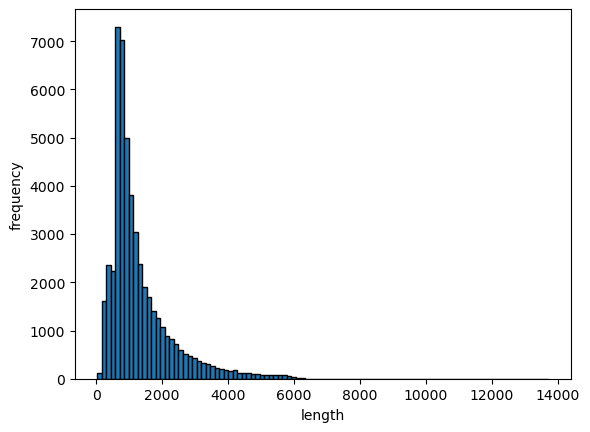

In [6]:
plt.hist(x='length',data=df,edgecolor = "black", bins = 100)
plt.xlabel('length')
plt.ylabel('frequency')

In [7]:
import string
string.punctuation

'!"#$%&\'()*+,-./:;<=>?@[\\]^_`{|}~'

In [8]:
def remove_br_tags(text):
    cleaned_text = text.replace('<br />', '')
    return cleaned_text

df['review']= df['review'].apply(remove_br_tags)


In [9]:
def nopunct(mess):
    nopunc = [x for x in mess if x not in string.punctuation]
    nopunc = ''.join(nopunc)
    return nopunc

In [10]:
df['review']= df['review'].apply(nopunct)

In [11]:
from nltk.corpus import stopwords
stopwords.words('english')[0:20]

['i',
 'me',
 'my',
 'myself',
 'we',
 'our',
 'ours',
 'ourselves',
 'you',
 "you're",
 "you've",
 "you'll",
 "you'd",
 'your',
 'yours',
 'yourself',
 'yourselves',
 'he',
 'him',
 'his']

In [12]:
def remove_stopword(mess):
    stpwrd = [char for char in mess if char not in stopwords.words('english')]
    stpwrd = ''.join(stpwrd)
    return stpwrd

In [13]:
import nltk
from nltk.corpus import wordnet
from nltk.tokenize import word_tokenize

In [14]:
nltk.download('punkt')
nltk.download('wordnet')

[nltk_data] Downloading package punkt to
[nltk_data]     C:\Users\Administrator\AppData\Roaming\nltk_data...
[nltk_data]   Package punkt is already up-to-date!
[nltk_data] Downloading package wordnet to
[nltk_data]     C:\Users\Administrator\AppData\Roaming\nltk_data...
[nltk_data]   Package wordnet is already up-to-date!


True

In [15]:
def convert_slang(text):
    words = word_tokenize(text)
    converted_words = []

    for word in words:
        # Get synonyms for the current word
        synonyms = wordnet.synsets(word)
        
        # Use the first synonym as replacement (if available)
        replacement = synonyms[0].lemmas()[0].name() if synonyms else word
        converted_words.append(replacement)

    converted_text = " ".join(converted_words)
    return converted_text

In [16]:
from sklearn.feature_extraction.text import CountVectorizer

In [17]:
bow_transformer = CountVectorizer(analyzer='word').fit(df['review'])

# Print total number of vocab words
print(len(bow_transformer.vocabulary_))

221457


In [18]:
reviews_bow = bow_transformer.transform(df['review'])

mess1 = df['review'][1]
bow1= bow_transformer.transform([mess1])

print('Shape of Sparse Matrix: ', reviews_bow.shape)
print('Amount of Non-Zero occurences: ', reviews_bow.nnz)

Shape of Sparse Matrix:  (50000, 221457)
Amount of Non-Zero occurences:  6805696


In [19]:
sparsity = (100.0 * reviews_bow.nnz / (reviews_bow.shape[0] * reviews_bow.shape[1]))
print('sparsity: {}'.format(round(sparsity)))

sparsity: 0


In [21]:
from sklearn.feature_extraction.text import TfidfTransformer

tfidf_transformer = TfidfTransformer().fit(reviews_bow)

tfidf4 = tfidf_transformer.transform(bow1)
#print(tfidf4)


In [22]:
#To transform the entire bag-of-words corpus into TF-IDF corpus at once
reviews_tfidf = tfidf_transformer.transform(reviews_bow)
print(reviews_tfidf.shape)

(50000, 221457)


In [23]:
from sklearn.naive_bayes import MultinomialNB
model = MultinomialNB().fit(reviews_tfidf, df['sentiment'])

#Testing
print('predicted:',model.predict(tfidf4)[0])
print('expected:', df['sentiment'][0])

#Predictions
all_predictions = model.predict(reviews_tfidf)
print(all_predictions)

predicted: positive
expected: positive
['positive' 'positive' 'positive' ... 'negative' 'negative' 'negative']


In [24]:
from sklearn.metrics import classification_report
print (classification_report(df['sentiment'], all_predictions))

              precision    recall  f1-score   support

    negative       0.90      0.93      0.91     25000
    positive       0.93      0.89      0.91     25000

    accuracy                           0.91     50000
   macro avg       0.91      0.91      0.91     50000
weighted avg       0.91      0.91      0.91     50000



In [25]:
from sklearn.model_selection import train_test_split

msg_train, msg_test, label_train, label_test = \
train_test_split(df['review'],df['sentiment'], test_size=0.2)

print(len(msg_train), len(msg_test), len(msg_train) + len(msg_test))

40000 10000 50000


In [26]:
from sklearn.pipeline import Pipeline

pipeline = Pipeline([
    ('bow', CountVectorizer(analyzer='word')),  # strings to token integer counts
    ('tfidf', TfidfTransformer()),  # integer counts to weighted TF-IDF scores
    ('classifier', MultinomialNB()),  # train on TF-IDF vectors w/ Naive Bayes classifier
])

In [27]:
pipeline.fit(msg_train,label_train)

Pipeline(steps=[('bow', CountVectorizer()), ('tfidf', TfidfTransformer()),
                ('classifier', MultinomialNB())])

In [28]:
predictions = pipeline.predict(msg_test)
print(classification_report(predictions,label_test))

              precision    recall  f1-score   support

    negative       0.88      0.85      0.87      5206
    positive       0.85      0.87      0.86      4794

    accuracy                           0.86     10000
   macro avg       0.86      0.86      0.86     10000
weighted avg       0.86      0.86      0.86     10000

